In [49]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import random
import cv2 as cv
import os

## Evaluation

This is just for final validation and dispalying final mAP for segmentation

In [50]:
model = YOLO('yolov8x-seg.pt')
model = YOLO('/home/m/macko70/projects/yolov8/runs/segment/train13/weights/yolov8x_seg_groceries.pt')
# metrics = model.val()

## Prediction

In [51]:
# pick one random image from validation set
image_dir = "/home/m/macko70/projects/yolov8/groceries_dataset/yolo_format_dataset/val/images/"
ann_dir = "/home/m/macko70/projects/yolov8/groceries_dataset/yolo_format_dataset/val/labels/"

file_list = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
random_file = random.choice(file_list)
image = image_dir + random_file
ann = ann_dir + random_file[:-4] + ".txt"

In [52]:
def generate_random_colors(n):
    colors = []
    for _ in range(n):
        colors.append((random.randint(20, 200), random.randint(20, 200), random.randint(20, 200)))
    return np.array(colors)

In [53]:
def color_masks(img, masks, masks_color):
    for mask, color in zip(masks, masks_color):
        masked_img = np.where(mask, color, img).astype(np.uint8)
        img = cv.addWeighted(img, 0.5, masked_img, 0.5, 0)
    return img

In [54]:
def get_segmentation_predictions(seg_points, orig_image):
    masks = []
    for i, seg_points in enumerate(seg_points):
        mask = np.zeros_like(orig_image)
        masks.append(cv.fillPoly(mask, [seg_points.astype(int)], (255, 255, 255)))
    masks = np.stack(masks, axis=0)
    print(masks.shape)
    masks_colors = generate_random_colors(len(masks))
    img_with_predicted_mask = color_masks(orig_image, masks, masks_colors)
    return img_with_predicted_mask
    

In [55]:
def unnormalize_seg_points(img_width, img_height, points):
    seg_points = []
    for p in points:
        seg_points.append(p * np.array([img_width, img_height]))
    return seg_points

In [56]:
def get_gt_segmentation_points(annotation_file):
    norm_seg_points = []
    with open(annotation_file, 'r') as file:
        for line in file:
            l = line.strip().split(" ")
            np.array(norm_seg_points.append(np.array(l[1:]).reshape(-1, 2).astype(float)))
    return norm_seg_points

In [57]:
results = model(image)


image 1/1 /home/m/macko70/projects/yolov8/groceries_dataset/yolo_format_dataset/val/images/20210430_sevt_edelia_0172.png: 768x1024 2 default_categorys, 45.5ms
Speed: 3.5ms preprocess, 45.5ms inference, 2.4ms postprocess per image at shape (1, 3, 1024, 1024)


In [58]:
norm_seg_points = get_gt_segmentation_points(ann)
gt_seg_points = unnormalize_seg_points(results[0].orig_img.shape[1], results[0].orig_img.shape[0], norm_seg_points)
img_with_gt_masks = get_segmentation_predictions(gt_seg_points, orig_image=results[0].orig_img)


(2, 1544, 2064, 3)


In [59]:
img_with_predicted_mask = get_segmentation_predictions(seg_points=results[0].masks.xy, orig_image=results[0].orig_img)

(2, 1544, 2064, 3)


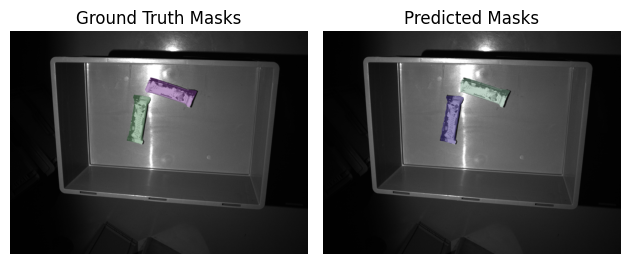

In [60]:
# Create a figure and subplot grid
fig, axs = plt.subplots(1, 2)

# Display images on subplots
axs[0].imshow(img_with_gt_masks)
axs[0].set_title('Ground Truth Masks')
axs[0].axis('off')

axs[1].imshow(img_with_predicted_mask)
axs[1].set_title('Predicted Masks')
axs[1].axis('off')

# Adjust subplot spacing
plt.tight_layout()

# Show the figure
plt.show()